In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1358344891157365008, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17626274119632715466
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13563992793905508870
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15876469556
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2649356333225389203
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
# from sklearn.metrics import log_loss
import sys
# import time
import math
import os
import pandas as pd
# from keras.callbacks import EarlyStopping
import numpy as np
# from glob import glob
# import cv2
# import skimage
# from skimage.transform import resize
from keras.utils.np_utils import to_categorical
# import keras
# from keras import layers
# from keras import models
# from keras import optimizers
# from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input,concatenate
# from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
# from keras.applications.vgg19 import VGG19
from keras.regularizers import l2, l1

import matplotlib.pyplot as plt
# from keras.layers import Input, concatenate
# from keras import optimizers, metrics, models
# from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.3.1
tensorflow Version 2.0.0


In [5]:
batch_size = 64
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)
epochs = 400

In [6]:
print(os.listdir("../input/"))

['payam-thesis', 'full-keras-pretrained-no-top']


In [7]:
# print(os.listdir("../input/full-keras-pretrained-no-top"))

In [8]:
train_dir = '../input/payam-thesis/train/'
test_dir = '../input/payam-thesis/test'

In [9]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [10]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 4611 images belonging to 3 classes.
Found 1152 images belonging to 3 classes.
Found 765 images belonging to 3 classes.


In [11]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 4611
nb_validation_samples: 1152
nb_test_samples: 765

predict_size_train: 73
predict_size_validation: 18
predict_size_test: 12

 num_classes: 3


In [33]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"

In [34]:
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import NASNetLarge, NASNetMobile
from keras.applications import MobileNet

In [35]:
input_tensor = Input(shape = input_shape)  

base_model1=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)
base_model2=DenseNet201(input_shape= input_shape,weights=denseNet201_weights, include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [36]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_2
1 zero_padding2d_3
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_4
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

881 average_pooling2d_16
882 conv5_block27_1_relu
883 conv2d_155
884 conv2d_158
885 conv2d_163
886 conv2d_164
887 conv5_block27_2_conv
888 batch_normalization_155
889 batch_normalization_158
890 batch_normalization_163
891 batch_normalization_164
892 conv5_block27_concat
893 activation_155
894 activation_158
895 activation_163
896 activation_164
897 conv5_block28_0_bn
898 mixed7
899 conv5_block28_0_relu
900 conv2d_167
901 conv5_block28_1_conv
902 batch_normalization_167
903 conv5_block28_1_bn
904 activation_167
905 conv5_block28_1_relu
906 conv2d_168
907 conv5_block28_2_conv
908 batch_normalization_168
909 conv5_block28_concat
910 activation_168
911 conv5_block29_0_bn
912 conv2d_165
913 conv2d_169
914 conv5_block29_0_relu
915 batch_normalization_165
916 batch_normalization_169
917 conv5_block29_1_conv
918 activation_165
919 activation_169
920 conv5_block29_1_bn
921 conv2d_166
922 conv2d_170
923 conv5_block29_1_relu
924 batch_normalization_166
925 batch_normalization_170
926 conv5_block

In [37]:
c1 = model.layers[585].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[601].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[634].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[667].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[708].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[739].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[787].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[835].output
c8 = GlobalAveragePooling2D()(c8) 

c9 = model.layers[883].output
c9 = GlobalAveragePooling2D()(c9) 

c10 = model.layers[933].output
c10 = GlobalAveragePooling2D()(c10) 

c11 = model.layers[954].output
c11 = GlobalAveragePooling2D()(c11) 

c12 = model.layers[996].output
c12 = GlobalAveragePooling2D()(c12) 

# c13 = model.layers[376].output
# c13 = GlobalAveragePooling2D()(c13) 

# c14 = model.layers[291].output
# c14 = GlobalAveragePooling2D()(c14) 

# c15 = model.layers[305].output
# c15 = GlobalAveragePooling2D()(c15) 

# c16 = model.layers[311].output
# c16 = GlobalAveragePooling2D()(c16) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [17]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "densenet201_InceptionResNetV2_descriptors"

In [53]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [54]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [55]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [41]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [56]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [77]:
model = Sequential()
model.add(Dense(4096, activation='tanh',kernel_regularizer=l2(1e-05),  bias_regularizer=l2(1e-06), activity_regularizer=l1(0.001)))
model.add(Dense(128, activation='tanh',kernel_regularizer=l2(1e-05),  bias_regularizer=l2(1e-06), activity_regularizer=l1(0.001)))
model.add(Dense(64, activation='tanh',kernel_regularizer=l2(1e-05),  bias_regularizer=l2(1e-06), activity_regularizer=l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.8)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

Train on 4611 samples, validate on 1152 samples
Epoch 1/400
 - 1s - loss: 31.5987 - accuracy: 0.5580 - val_loss: 21.3849 - val_accuracy: 0.7708
Epoch 2/400
 - 1s - loss: 16.5304 - accuracy: 0.6803 - val_loss: 17.0359 - val_accuracy: 0.5590
Epoch 3/400
 - 1s - loss: 13.7897 - accuracy: 0.7311 - val_loss: 15.6881 - val_accuracy: 0.8186
Epoch 4/400
 - 1s - loss: 12.4502 - accuracy: 0.7315 - val_loss: 15.2242 - val_accuracy: 0.5408
Epoch 5/400
 - 1s - loss: 11.6037 - accuracy: 0.7508 - val_loss: 14.7452 - val_accuracy: 0.2856
Epoch 6/400
 - 1s - loss: 10.9907 - accuracy: 0.7573 - val_loss: 14.0334 - val_accuracy: 0.7109
Epoch 7/400
 - 1s - loss: 10.5000 - accuracy: 0.7801 - val_loss: 13.2516 - val_accuracy: 0.5703
Epoch 8/400
 - 1s - loss: 10.0967 - accuracy: 0.7536 - val_loss: 12.9088 - val_accuracy: 0.6840
Epoch 9/400
 - 1s - loss: 9.7619 - accuracy: 0.7745 - val_loss: 12.8772 - val_accuracy: 0.6155
Epoch 10/400
 - 1s - loss: 9.4870 - accuracy: 0.7747 - val_loss: 12.0700 - val_accuracy: 

Epoch 87/400
 - 1s - loss: 5.3831 - accuracy: 0.9503 - val_loss: 8.9215 - val_accuracy: 0.6675
Epoch 88/400
 - 1s - loss: 5.3956 - accuracy: 0.9445 - val_loss: 8.2196 - val_accuracy: 0.9332
Epoch 89/400
 - 1s - loss: 5.3715 - accuracy: 0.9497 - val_loss: 8.6602 - val_accuracy: 0.8672
Epoch 90/400
 - 1s - loss: 5.3617 - accuracy: 0.9447 - val_loss: 9.5612 - val_accuracy: 0.7257
Epoch 91/400
 - 1s - loss: 5.3372 - accuracy: 0.9560 - val_loss: 8.8331 - val_accuracy: 0.7491
Epoch 92/400
 - 1s - loss: 5.3489 - accuracy: 0.9477 - val_loss: 9.0520 - val_accuracy: 0.4470
Epoch 93/400
 - 1s - loss: 5.3229 - accuracy: 0.9488 - val_loss: 8.3540 - val_accuracy: 0.9167
Epoch 94/400
 - 1s - loss: 5.3051 - accuracy: 0.9484 - val_loss: 8.1604 - val_accuracy: 0.8828
Epoch 95/400
 - 1s - loss: 5.2790 - accuracy: 0.9540 - val_loss: 8.4233 - val_accuracy: 0.9332
Epoch 96/400
 - 1s - loss: 5.2740 - accuracy: 0.9545 - val_loss: 8.3342 - val_accuracy: 0.9392
Epoch 97/400
 - 1s - loss: 5.2761 - accuracy: 0.95

Epoch 173/400
 - 1s - loss: 4.7240 - accuracy: 0.9670 - val_loss: 7.4714 - val_accuracy: 0.9887
Epoch 174/400
 - 1s - loss: 4.7058 - accuracy: 0.9692 - val_loss: 8.5447 - val_accuracy: 0.7951
Epoch 175/400
 - 1s - loss: 4.7074 - accuracy: 0.9766 - val_loss: 7.9103 - val_accuracy: 0.8698
Epoch 176/400
 - 1s - loss: 4.7065 - accuracy: 0.9768 - val_loss: 8.7853 - val_accuracy: 0.6519
Epoch 177/400
 - 1s - loss: 4.7220 - accuracy: 0.9707 - val_loss: 8.3663 - val_accuracy: 0.6450
Epoch 178/400
 - 1s - loss: 4.7082 - accuracy: 0.9712 - val_loss: 8.1188 - val_accuracy: 0.8932
Epoch 179/400
 - 1s - loss: 4.6987 - accuracy: 0.9692 - val_loss: 7.4509 - val_accuracy: 0.9757
Epoch 180/400
 - 1s - loss: 4.6530 - accuracy: 0.9796 - val_loss: 8.6383 - val_accuracy: 0.5859
Epoch 181/400
 - 1s - loss: 4.7404 - accuracy: 0.9670 - val_loss: 7.6724 - val_accuracy: 0.9661
Epoch 182/400
 - 1s - loss: 4.6799 - accuracy: 0.9735 - val_loss: 7.5362 - val_accuracy: 0.9201
Epoch 183/400
 - 1s - loss: 4.6694 - acc

Epoch 259/400
 - 1s - loss: 4.4494 - accuracy: 0.9853 - val_loss: 7.6265 - val_accuracy: 0.9774
Epoch 260/400
 - 1s - loss: 4.4794 - accuracy: 0.9805 - val_loss: 8.6097 - val_accuracy: 0.9115
Epoch 261/400
 - 1s - loss: 4.5156 - accuracy: 0.9827 - val_loss: 7.4831 - val_accuracy: 0.8941
Epoch 262/400
 - 1s - loss: 4.5089 - accuracy: 0.9792 - val_loss: 8.0558 - val_accuracy: 0.9149
Epoch 263/400
 - 1s - loss: 4.4741 - accuracy: 0.9820 - val_loss: 7.3383 - val_accuracy: 0.9913
Epoch 264/400
 - 1s - loss: 4.4903 - accuracy: 0.9831 - val_loss: 7.3629 - val_accuracy: 0.9696
Epoch 265/400
 - 1s - loss: 4.4697 - accuracy: 0.9848 - val_loss: 7.9232 - val_accuracy: 0.9418
Epoch 266/400
 - 1s - loss: 4.4694 - accuracy: 0.9861 - val_loss: 7.5133 - val_accuracy: 0.9913
Epoch 267/400
 - 1s - loss: 4.4448 - accuracy: 0.9848 - val_loss: 9.6287 - val_accuracy: 0.5807
Epoch 268/400
 - 1s - loss: 4.4909 - accuracy: 0.9824 - val_loss: 7.4120 - val_accuracy: 0.9896
Epoch 269/400
 - 1s - loss: 4.4696 - acc

Epoch 345/400
 - 1s - loss: 4.4554 - accuracy: 0.9850 - val_loss: 7.7282 - val_accuracy: 0.8073
Epoch 346/400
 - 1s - loss: 4.4207 - accuracy: 0.9859 - val_loss: 7.5011 - val_accuracy: 0.9870
Epoch 347/400
 - 1s - loss: 4.4340 - accuracy: 0.9876 - val_loss: 7.0119 - val_accuracy: 0.9340
Epoch 348/400
 - 1s - loss: 4.3785 - accuracy: 0.9889 - val_loss: 8.0822 - val_accuracy: 0.8472
Epoch 349/400
 - 1s - loss: 4.4203 - accuracy: 0.9889 - val_loss: 8.7706 - val_accuracy: 0.7101
Epoch 350/400
 - 1s - loss: 4.4565 - accuracy: 0.9842 - val_loss: 7.2450 - val_accuracy: 0.9766
Epoch 351/400
 - 1s - loss: 4.4396 - accuracy: 0.9853 - val_loss: 8.1595 - val_accuracy: 0.7222
Epoch 352/400
 - 1s - loss: 4.4595 - accuracy: 0.9824 - val_loss: 7.5882 - val_accuracy: 0.9722
Epoch 353/400
 - 1s - loss: 4.4049 - accuracy: 0.9868 - val_loss: 7.9310 - val_accuracy: 0.8420
Epoch 354/400
 - 1s - loss: 4.4128 - accuracy: 0.9866 - val_loss: 7.4551 - val_accuracy: 0.9253
Epoch 355/400
 - 1s - loss: 4.4272 - acc

In [78]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

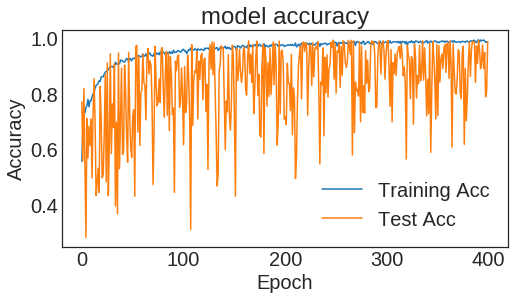

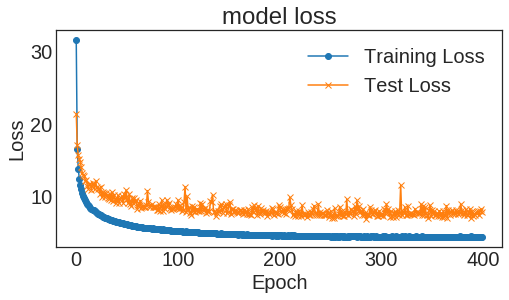

<Figure size 432x288 with 0 Axes>

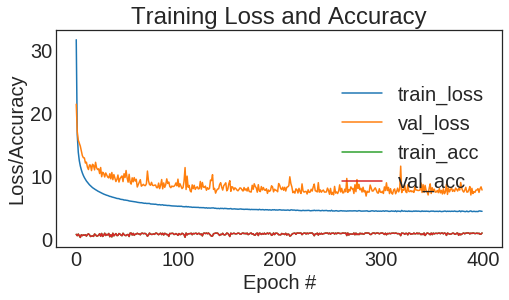

In [79]:
import seaborn
plt.style.use('seaborn-white')
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='lower right')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'x-')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper right')

plt.show()

plt.figure()
plt.figure(figsize=(8,4))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

In [80]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

1152/1152 [==============================] - 0s 64us/step
Validation Accuracy: 98.6111%
Validation Loss: 7.79441483815511


In [81]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9973856209150327


Confusion Matrix
[[329   0   0]
 [  1 209   1]
 [  0   0 225]]


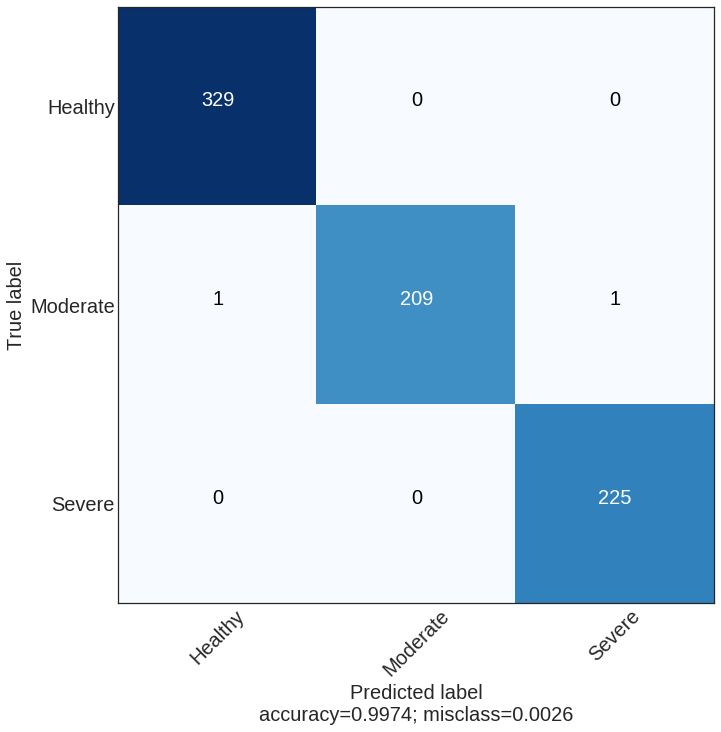

In [82]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[329   0   0]
 [  1 209   1]
 [  0   0 225]]
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       329
    Moderate       1.00      0.99      1.00       211
      Severe       1.00      1.00      1.00       225

    accuracy                           1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765



In [84]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  99.69696969696969
Specificity :  100.0


In [85]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

765/765 [==============================] - 0s 62us/step
Precision =  0.9973953661199887
Recall =  0.9973856209150327
f1_score =  0.9973818372131105


In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9979272850832483


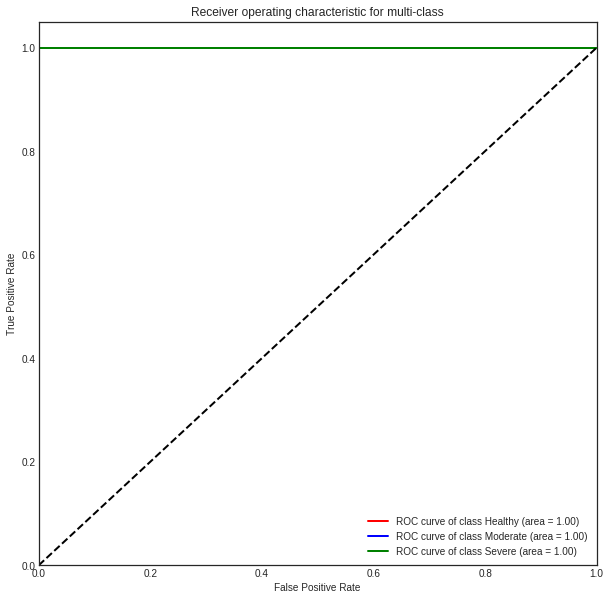

In [87]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2])
y_pred_binary = y_pred_probabilities
n_classes=3
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()